# Exercise 3 ... and maybe 4, 5, and 6

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

# EITHER: load from previously saved arrays
base = Path("Fully_Pre_processed_Data")
X_path = base / "X.npy"
fn_path = base / "filenames.csv"

if X_path.exists() and fn_path.exists():
    X = np.load(X_path)                    # shape (N, 4096) for 64x64
    filenames = pd.read_csv(fn_path)["filename"].tolist()
else:
    # OR: build from folder of 64x64 grayscale images
    in_dir = Path("processed_64x64_gray")  # change if different
    files = sorted([p for p in in_dir.iterdir() if p.suffix.lower() in {".jpg"}])
    X = []
    filenames = []
    for p in files:
        img = Image.open(p).convert("L").resize((64,64))    # ensure consistent size
        X.append(np.array(img, dtype=np.float32).ravel())
        filenames.append(p.name)
    X = np.stack(X)

print("X shape:", X.shape, " (N images x D pixels)")


X shape: (280, 4096)  (N images x D pixels)


In [3]:
# Example of building a single target vector y (mean of rating1 & rating2 per image for YOUR run)
# Change your student ID and path as needed.
my_csv = pd.read_csv("Experiment_1_Results/s215225.txt")  # columns: filename, rating1, rating2
my_csv["y_mean"] = my_csv[["rating1","rating2"]].mean(axis=1)

# Map from filename -> y_mean and align to X order
y_map = dict(zip(my_csv["filename"], my_csv["y_mean"]))
y = np.array([y_map.get(fn, np.nan) for fn in filenames], dtype=float)

print("y shape:", y.shape, " (NaN means that filename wasn't in the ratings file)")


y shape: (280,)  (NaN means that filename wasn't in the ratings file)


In [4]:
# Put pixels on [0,1] for numerical stability (still okay per your prof’s rule)
X01 = X / 255.0

# Compute average image (across all images), then center
mean_image = X01.mean(axis=0, keepdims=True)     # shape (1, D)
X_centered = X01 - mean_image                    # (N, D)

print("Centered X with shape:", X_centered.shape)


Centered X with shape: (280, 4096)


In [6]:
from sklearn.decomposition import PCA

# Choose n_components; start generous (e.g., 200) then decide from variance explained
n_components = min(200, X_centered.shape[0]-1, X_centered.shape[1])
pca = PCA(n_components=n_components, svd_solver="randomized", random_state=0)
scores = pca.fit_transform(X_centered)      # shape: (N, n_components)
components = pca.components_                # shape: (n_components, D)
explained = pca.explained_variance_ratio_   # length n_components

print("scores shape:", scores.shape)
print("components shape:", components.shape)
print("Total variance explained:", explained.sum())


scores shape: (280, 200)
components shape: (200, 4096)
Total variance explained: 0.9952983


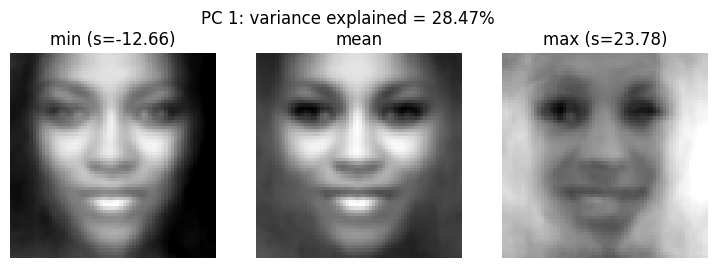

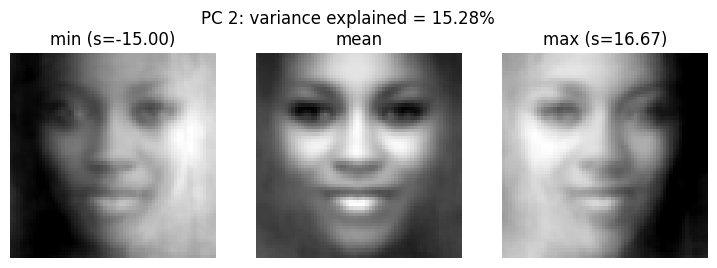

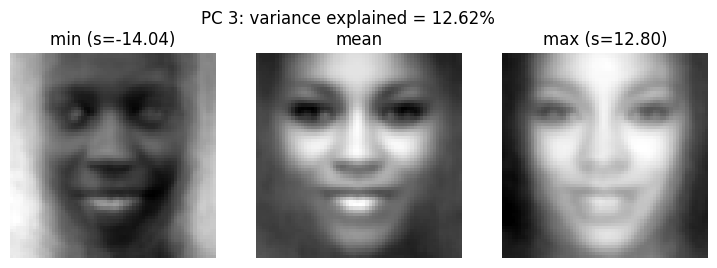

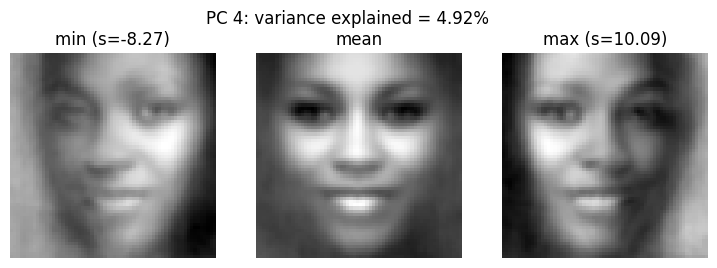

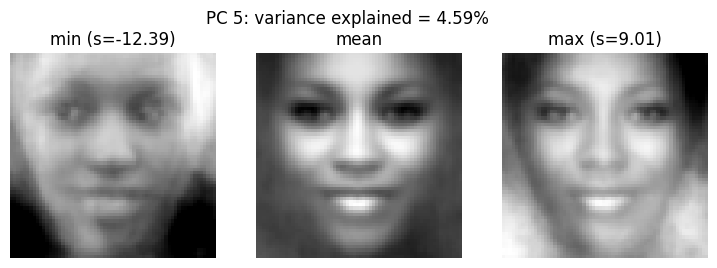

In [7]:
import matplotlib.pyplot as plt

H = W = 64  # adjust if not 64x64

def show_pc_effect(k):
    """Visualize PC k as three images: min-score, mean, max-score."""
    pc = components[k]                               # (D,)
    s = scores[:, k]                                 # all scores on PC k
    s_min, s_max = float(s.min()), float(s.max())

    # Reconstruct images: mean_image + score * component
    # (mean_image and components are in [0,1]-centered space)
    im_min = (mean_image + s_min * pc).reshape(H, W)
    im_avg = (mean_image).reshape(H, W)
    im_max = (mean_image + s_max * pc).reshape(H, W)

    # Clip to [0,1] just for display
    im_min = np.clip(im_min, 0, 1)
    im_avg = np.clip(im_avg, 0, 1)
    im_max = np.clip(im_max, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    for ax, im, title in zip(axes, [im_min, im_avg, im_max], [f"min (s={s_min:.2f})", "mean", f"max (s={s_max:.2f})"]):
        ax.imshow(im, cmap="gray")
        ax.set_title(title)
        ax.axis("off")
    fig.suptitle(f"PC {k+1}: variance explained = {explained[k]*100:.2f}%")
    plt.show()

# Example: visualize first 5 PCs
for k in range(5):
    show_pc_effect(k)


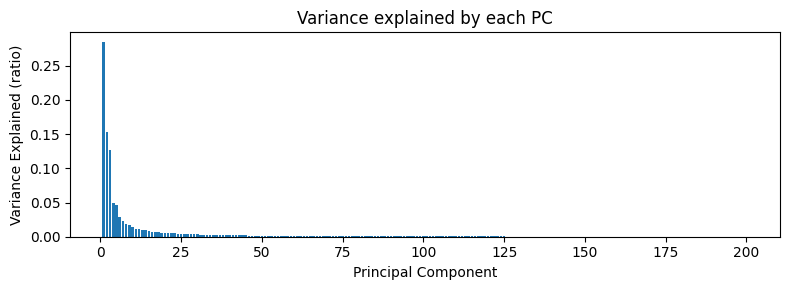

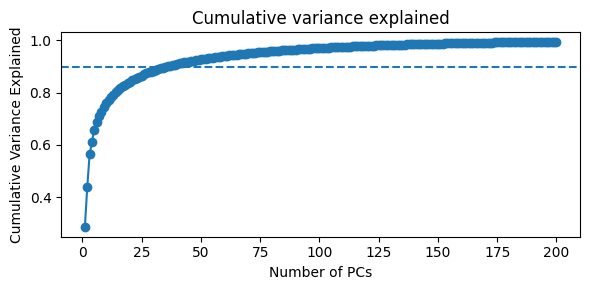

PCs to reach 90% variance: 36


In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,3))
plt.bar(np.arange(1, len(explained)+1), explained)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (ratio)")
plt.title("Variance explained by each PC")
plt.tight_layout()
plt.show()

# Cumulative variance to pick a cutoff (e.g., 90%)
cum = np.cumsum(explained)
plt.figure(figsize=(6,3))
plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
plt.axhline(0.9, linestyle="--")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative variance explained")
plt.tight_layout()
plt.show()

# Choose K by a rule (e.g., first K reaching 90% cumulative)
K90 = int(np.searchsorted(cum, 0.90) + 1)
print("PCs to reach 90% variance:", K90)


In [9]:
K = K90     # or any number you choose after inspecting the plots
X_pca = scores[:, :K]          # predictors
np.save("pca_scores_X.npy", X_pca)

# optional: save the mapping and PCA objects for reproducibility
np.save("pca_mean_image.npy", mean_image)
np.save("pca_components.npy", components)
np.save("pca_explained_ratio.npy", explained)
pd.Series(filenames, name="filename").to_csv("pca_filenames.csv", index=False)

print("Saved:", "pca_scores_X.npy (predictors), pca_components.npy, pca_mean_image.npy, pca_explained_ratio.npy")


Saved: pca_scores_X.npy (predictors), pca_components.npy, pca_mean_image.npy, pca_explained_ratio.npy


# 4. Linear Model Shit

In [ ]:
import numpy as np
import pandas as pd

STUDENT_ID = "s215221"  # Also try s21225!

# Load PCA outputs
scores     = np.load("pca_scores_X.npy")             # (N, K_all)
explained  = np.load("pca_explained_ratio.npy")      # (K_all,)
filenames  = pd.read_csv("pca_filenames.csv")["filename"].tolist()

# Choose the PCs. I think we should go with 36 because of explained variance (you found 36 ~90%)
K = 36
X_pca = scores[:, :K]   # (N, K)

# Load participant ratings, build y = mean of the two ratings per image
df = pd.read_csv(f"Experiment_1_Results/{STUDENT_ID}.txt")   # filename, rating1, rating2
df["y_raw"] = df[["rating1","rating2"]].mean(axis=1)

# Min–max normalize to [1,5] (only if range is narrower than [1,5])
def minmax_to_1_5(y):
    ymin, ymax = float(np.min(y)), float(np.max(y))
    if np.isclose(ymax, ymin):
        # edge case: participant used a single value -> return all 3s (midpoint)
        return np.full_like(y, 3.0, dtype=float)
    y0 = (y - ymin) / (ymax - ymin)
    return 1 + 4*y0

# Align y to X order by filename
y_map = dict(zip(df["filename"], df["y_raw"]))
y_raw = np.array([y_map.get(fn, np.nan) for fn in filenames], dtype=float)

# Keep only rows with available ratings
mask = ~np.isnan(y_raw)
X_pca = X_pca[mask]
filenames_aligned = np.array(filenames)[mask]
y_raw = y_raw[mask]

# Normalize (optional but recommended if they didn't use full 1–5)
y_norm = minmax_to_1_5(y_raw)

print("X_pca shape:", X_pca.shape, "| y_norm shape:", y_norm.shape)


X_pca shape: (280, 36) | y_norm shape: (280,)


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
#Can spend more time here trying different K values. But for now I think 36 should be good.

est = LinearRegression()
cv  = KFold(n_splits=5, shuffle=True, random_state=0)

n_features = X_pca.shape[1]

best_score = -np.inf
best_mask  = None
best_n     = None

# Forward selection: n must be < n_features
for n in range(1, max(1, n_features)):  # 1 .. n_features-1
    sfs = SequentialFeatureSelector(
        estimator=est,
        n_features_to_select=n,
        direction="forward",
        scoring="r2",
        cv=cv,
        n_jobs=-1
    ).fit(X_pca, y_norm)

    mask = sfs.get_support()
    cv_score = cross_val_score(est, X_pca[:, mask], y_norm, cv=cv, scoring="r2").mean()

    if cv_score > best_score:
        best_score = cv_score
        best_mask  = mask
        best_n     = n

# Also evaluate the full feature set as a baseline
full_cv = cross_val_score(est, X_pca, y_norm, cv=cv, scoring="r2").mean()
if full_cv > best_score:
    best_score = full_cv
    best_mask  = np.ones(n_features, dtype=bool)
    best_n     = n_features

print(f"Best CV R squared= {best_score:.3f} with {best_n} selected PCs.")

# Fit final model on the selected subset
X_sel = X_pca[:, best_mask]
final = LinearRegression().fit(X_sel, y_norm)
print("Final train R squared: ", final.score(X_sel, y_norm))

selected_pc_indices_within_K = np.where(best_mask)[0]
coefs = final.coef_
print("Selected PCs (within first K):", selected_pc_indices_within_K.tolist())


Best CV R squared= 0.509 with 18 selected PCs.
Final train R squared:  0.5521800323849908
Selected PCs (within first K): [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 18, 20, 23, 26, 27, 33]


In [14]:
import numpy as np
import pandas as pd

# From previous step:
# selected_pc_indices_within_K : array of indices in 0..K-1
# coefs                        : regression coefficients aligned with the selected PCs
# explained                    : variance explained per PC (length >= K)
# K                            : number of kept PCs by variance (e.g., 36)

order = np.argsort(np.abs(coefs))[::-1]
selected_ordered = selected_pc_indices_within_K[order]
coefs_ordered = coefs[order]

summary = pd.DataFrame({
    "pc_within_K_0based": selected_ordered,
    "pc_1based": selected_ordered + 1,
    "coef": coefs_ordered,
    "abs_coef": np.abs(coefs_ordered),
    "var_explained_pct": (explained[selected_ordered] * 100)
})
summary

,pc_within_K_0based,pc_1based,coef,abs_coef,var_explained_pct
0,9,10,0.379119,0.379119,1.379694
1,18,19,-0.270834,0.270834,0.592535
2,10,11,-0.241841,0.241841,1.158356
3,6,7,0.152400,0.152400,2.230483
4,27,28,0.147928,0.147928,0.362775
5,15,16,-0.146239,0.146239,0.761018
6,11,12,-0.132786,0.132786,1.134945
7,7,8,0.132054,0.132054,1.821450
8,23,24,0.131157,0.131157,0.432289
9,20,21,0.125754,0.125754,0.529566


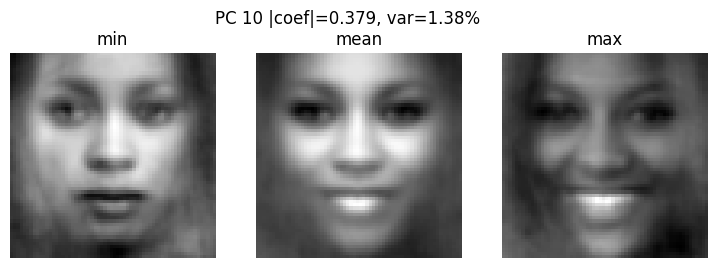

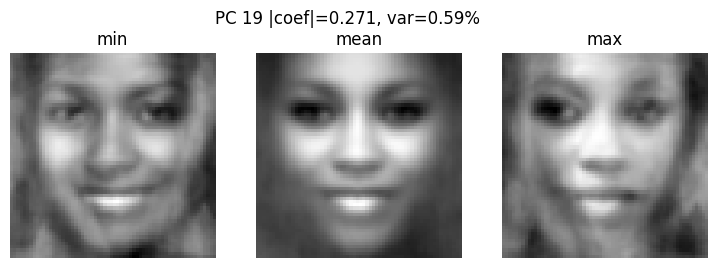

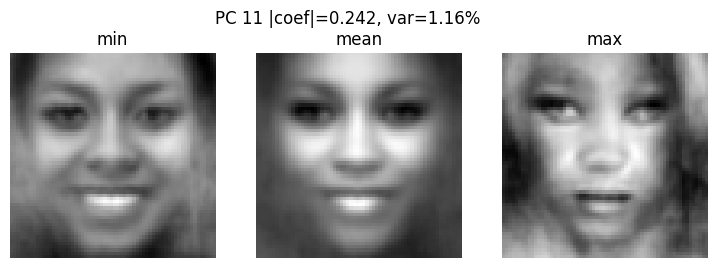

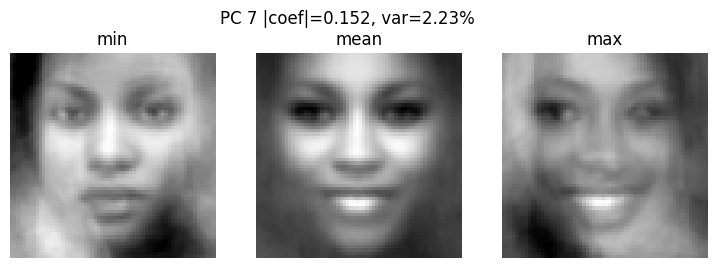

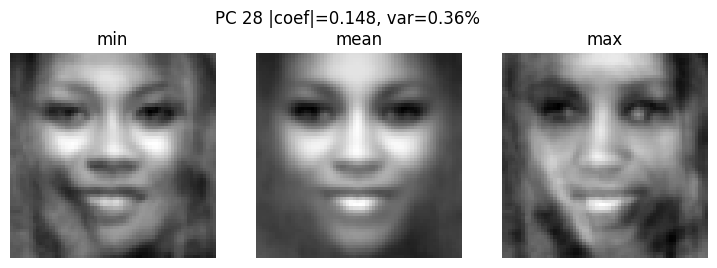

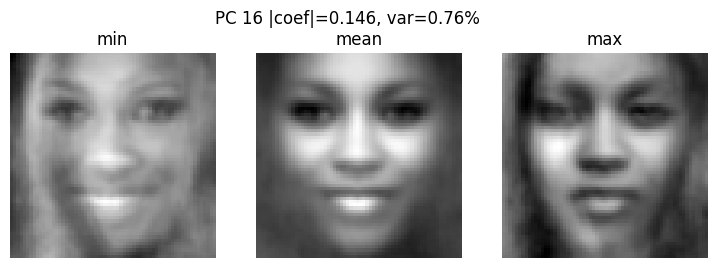

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assumptions we already have in scope:
# components: (>=K, D)
# scores:     (N_all, >=K)
# X_pca:      (N_used, K)     # scores restricted to modeled images and first K PCs
# explained:  (>=K,)
# mean_image: (1, D) or (D,)
# selected_ordered: indices in 0..K-1, ordered by |coef|
# coefs_ordered:    coefficients in that same order
H= 64
W = 64

# Ensure mean_image is 1D length D
mean_vec = np.asarray(mean_image).ravel()

def show_pc_effect(global_k, s_subset=None, title_note=""):
    pc = components[global_k]                 # (D,)
    s = s_subset if s_subset is not None else scores[:, global_k]
    s_min, s_max = float(np.min(s)), float(np.max(s))

    im_min = (mean_vec + s_min * pc).reshape(H, W)
    im_avg = (mean_vec).reshape(H, W)
    im_max = (mean_vec + s_max * pc).reshape(H, W)

    im_min = np.clip(im_min, 0, 1)
    im_avg = np.clip(im_avg, 0, 1)
    im_max = np.clip(im_max, 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    for ax, im, t in zip(axes, [im_min, im_avg, im_max], ["min", "mean", "max"]):
        ax.imshow(im, cmap="gray")
        ax.set_title(t)
        ax.axis("off")
    fig.suptitle(f"PC {global_k+1} {title_note}")
    plt.show()

# Show the top 6 most influential PCs by |coef|
top_to_show = min(6, len(selected_ordered))
for j in range(top_to_show):
    gk = int(selected_ordered[j])     # 0..K-1 (since you used the first K PCs)
    s_sub = X_pca[:, gk]              # scores over the modeled images for this PC
    show_pc_effect(
        global_k=gk,
        s_subset=s_sub,
        title_note=f"|coef|={abs(coefs_ordered[j]):.3f}, var={explained[gk]*100:.2f}%"
    )


# 5. Generate Synthetic Images 

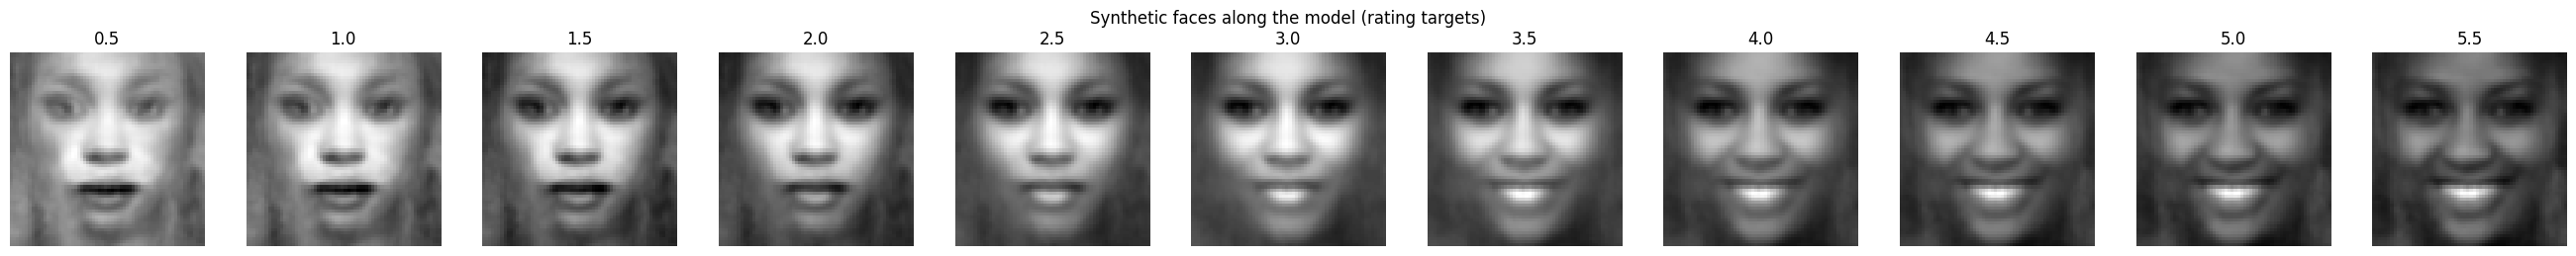

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs I already have:
# - components: (>=K, D)            # PCA components as row vectors
# - mean_image: (1, D) or (D,)      # average image used for PCA
# - selected_pc_indices_within_K    # 0-based indices among your first K PCs
# - coefs                            # regression coefficients for those selected PCs (same order as selected_pc_indices_within_K)
# - final.intercept_                 # regression intercept
# - H, W = 64, 64                    # image size

mean_vec = np.asarray(mean_image).ravel()
H, W = 64, 64

# Build pixel-space direction beta = sum_j w_j * PC_j  (only over selected PCs)
beta_pixels = np.zeros_like(mean_vec, dtype=float)
for idx_withinK, w in zip(selected_pc_indices_within_K, coefs):
    beta_pixels += w * components[idx_withinK]   # idx_withinK indexes the same global PCs because you used the first K

# Precompute ||w||^2 for mapping rating -> alpha
w_norm_sq = float(np.dot(coefs, coefs))
b0 = float(final.intercept_)

def synth_from_rating(y_star):
    """Generate a synthetic image corresponding to desired rating y_star (on your modeling scale, e.g., 1..5)."""
    if w_norm_sq == 0:
        # degenerate case (no signal) -> return mean
        x = mean_vec.copy()
    else:
        alpha = (y_star - b0) / w_norm_sq
        x = mean_vec + alpha * beta_pixels
    x = np.clip(x, 0, 1)   # keep displayable
    return x.reshape(H, W)

# The 11 requested targets: 1..5 plus the six half-steps
targets = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]

# Generate and show as a grid
n = len(targets)
cols = 11
rows = 1
fig, axes = plt.subplots(rows, cols, figsize=(2.4*cols, 2.6))
for i, ystar in enumerate(targets):
    ax = axes[i] if rows == 1 else axes[i//cols, i%cols]
    img = synth_from_rating(ystar)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{ystar:.1f}")
    ax.axis("off")
plt.suptitle("Synthetic faces along the model (0.5 to 5.5)")
plt.tight_layout()
plt.show()


In [20]:
from PIL import Image

outdir = "Synthetic_Faces"
import os; os.makedirs(outdir, exist_ok=True)

for ystar in targets:
    img = (synth_from_rating(ystar) * 255).astype(np.uint8)
    Image.fromarray(img, mode="L").save(f"{outdir}/synthetic_{ystar:.1f}.png")

print("Saved to:", outdir)

Saved to: Synthetic_Faces


In [21]:
from pathlib import Path
import re
import pandas as pd

SYN_DIR = Path("Synthetic_Faces")  # folder with 11 images you generated
pat = re.compile(r"synthetic_([0-9]+(?:\.[0-9]+)?)\.png$", re.IGNORECASE)

rows = []
for p in sorted(SYN_DIR.iterdir()):
    m = pat.match(p.name)
    if m:
        y_pred = float(m.group(1))
        rows.append({"filename": p.name, "predicted": y_pred})
        
syn_manifest = pd.DataFrame(rows).sort_values("predicted").reset_index(drop=True)
display(syn_manifest)


,filename,predicted
0,synthetic_0.5.png,0.5
1,synthetic_1.0.png,1.0
2,synthetic_1.5.png,1.5
3,synthetic_2.0.png,2.0
4,synthetic_2.5.png,2.5
5,synthetic_3.0.png,3.0
6,synthetic_3.5.png,3.5
7,synthetic_4.0.png,4.0
8,synthetic_4.5.png,4.5
9,synthetic_5.0.png,5.0


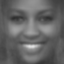

Experiment 2 completed for this participant.


In [22]:
from pathlib import Path
from IPython.display import display, Image as IPyImage
import random, csv
import pandas as pd

# Configs
STUDENT_ID = "s215221"                 # change to your student ID
SYN_DIR    = Path("Synthetic_Faces")   # folder with your 11 images
MANIFEST   = syn_manifest              # DataFrame with columns: filename, predicted
N_REPS     = 10                        # at least 10 as per the spec
OUT_DIR    = Path("Experiment_2_Results")
R_MIN, R_MAX = 1, 5                    # 1–5 scale



OUT_DIR.mkdir(parents=True, exist_ok=True)
trial_log = OUT_DIR / f"{STUDENT_ID}.txt"

# Build full trial list (each image repeated N_REPS times)
trials = []
for _, row in MANIFEST.iterrows():
    for _ in range(N_REPS):
        trials.append({"filename": row["filename"], "predicted": float(row["predicted"])})

# Load existing progress (resume)
done = []
if trial_log.exists():
    df_done = pd.read_csv(trial_log)
    for r in df_done.to_dict("records"):
        done.append((r["filename"], r["predicted"], r["response"]))
    print(f"Resuming: already logged {len(done)} trials.")
else:
    # Write header
    with open(trial_log, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["trial_index","filename","predicted","response"])
        writer.writeheader()

# Remove completed trials
remaining = []
done_set = {(fn, float(pred)) for (fn, pred, _) in done}
for t in trials:
    if (t["filename"], t["predicted"]) in done_set:
        # Count how many times this pair appears in 'done' to avoid overskipping
        pass
    remaining.append(t)

# We need to remove as many as already recorded for each (filename,predicted)
# Build counts needed vs done
import collections
need_counts = collections.Counter((t["filename"], t["predicted"]) for t in trials)
done_counts = collections.Counter((fn, float(pred)) for (fn, pred, _) in done)

final_remaining = []
for key, need in need_counts.items():
    done_n = done_counts.get(key, 0)
    to_do = max(0, need - done_n)
    filename, predicted = key
    final_remaining.extend([{"filename": filename, "predicted": predicted}] * to_do)

random.shuffle(final_remaining)
print(f"Trials remaining this run: {len(final_remaining)}  (Total planned: {len(trials)})")

# Present trials
from IPython.display import clear_output
for idx, t in enumerate(final_remaining, start=len(done)):
    clear_output(wait=True)
    img_path = SYN_DIR / t["filename"]
    display(IPyImage(filename=str(img_path)))
    while True:
        raw = input(f"[{idx+1}/{len(trials)}] Rate {t['filename']} (pred={t['predicted']}) on {R_MIN}-{R_MAX} (or 'q' to quit): ").strip()
        if raw.lower() in {"q","quit","exit"}:
            print("Stopping early. Progress saved. Re-run this cell to resume.")
            raise SystemExit
        try:
            r = int(raw)
            if R_MIN <= r <= R_MAX:
                break
            else:
                print(f"Please enter an integer in {R_MIN}..{R_MAX}.")
        except:
            print("Please enter a valid integer.")
    with open(trial_log, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["trial_index","filename","predicted","response"])
        writer.writerow({
            "trial_index": idx,
            "filename": t["filename"],
            "predicted": t["predicted"],
            "response": r
        })
print("Experiment 2 completed for this participant.")


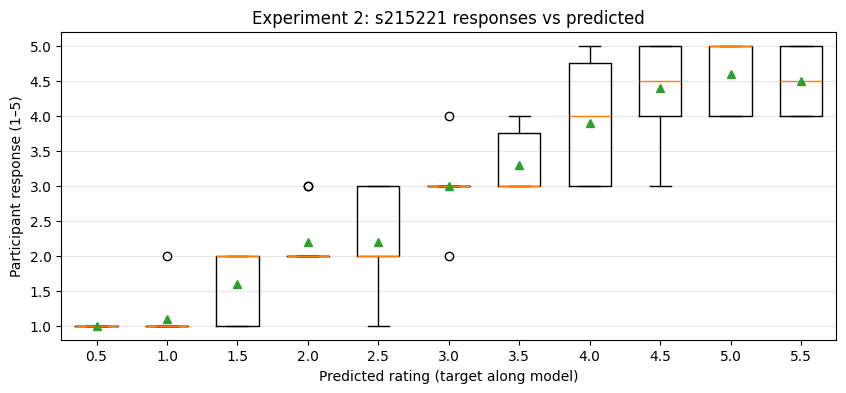

Spearman coefficient (rho) = 0.917 (p=5.26e-45)


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

STUDENT_ID = "s215221"  # same as above
df = pd.read_csv(f"Experiment_2_Results/{STUDENT_ID}.txt")

# Ensure numeric
df["predicted"] = df["predicted"].astype(float)
df["response"]  = df["response"].astype(int)

# Box plot: responses grouped by predicted rating
levels = sorted(df["predicted"].unique())  # e.g., [0.5,1,1.5,2,...,5.5]
data_by_level = [df.loc[df["predicted"]==lv, "response"].values for lv in levels]

plt.figure(figsize=(10,4))
plt.boxplot(data_by_level, positions=range(len(levels)), widths=0.6, showmeans=True)
plt.xticks(range(len(levels)), [str(lv) for lv in levels], rotation=0)
plt.xlabel("Predicted rating (target along model)")
plt.ylabel("Participant response (1–5)")
plt.title(f"Experiment 2: {STUDENT_ID} responses vs predicted")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Spearman's rho: use all trials (predicted vs response)
rho, p = spearmanr(df["predicted"], df["response"])
print(f"Spearman coefficient (rho) = {rho:.3f} (p={p:.2e})")


----------
Basically just combine our experiment 2 results here...

In [ ]:
participant_ids = ["Viraj", "Anka", "Mustafa"]  # change
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

rhos = []
for sid in participant_ids:
    dfp = pd.read_csv(f"Experiment_2_Results/{sid}.txt")
    dfp["predicted"] = dfp["predicted"].astype(float)
    dfp["response"]  = dfp["response"].astype(int)
    rho, p = spearmanr(dfp["predicted"], dfp["response"])
    rhos.append((sid, rho, p))

print("Spearman rho per participant:")
for sid, rho, p in rhos:
    print(f"  {sid}: rho={rho:.3f} (p={p:.2e})")

# Optional: one combined boxplot per participant (wide figure)
levels = sorted(pd.read_csv(f"Experiment_2_Results/{participant_ids[0]}.txt")["predicted"].unique())
fig, axes = plt.subplots(1, len(participant_ids), figsize=(5*len(participant_ids), 4), sharey=True)
if len(participant_ids) == 1:
    axes = [axes]
for ax, sid in zip(axes, participant_ids):
    dfp = pd.read_csv(f"Experiment_2_Results/{sid}.txt")
    data_by_level = [dfp.loc[dfp["predicted"]==lv, "response"].values for lv in levels]
    ax.boxplot(data_by_level, positions=range(len(levels)), widths=0.6, showmeans=True)
    ax.set_title(f"{sid}")
    ax.set_xticks(range(len(levels)))
    ax.set_xticklabels([str(lv) for lv in levels], rotation=0)
    ax.set_xlabel("Predicted"); ax.grid(axis="y", alpha=0.3)
axes[0].set_ylabel("Response (1 to 5)")
fig.suptitle("Experiment 2: Ratings vs predicted per participant")
plt.tight_layout()
plt.show()
